In [11]:
%load_ext autoreload
%autoreload 2
import scipy
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyseir.models import suppression_policies
from pyseir import load_data
from pyseir.inference.model_fitter import ModelFitter
from pyseir.models.seir_model import SEIRModel
from pyseir.models.suppression_policies import generate_triggered_suppression_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
DEFAULT_PARAM = dict(sigma = 1 / 5.2, 
                     delta = 1 / 2.5,
                     gamma = 0.01,
                     A_initial = 0)

In [23]:
new_cases = lambda x: np.insert(x[1:] - x[:-1], 0, x[0])

In [24]:
county_metadata = load_data.load_county_metadata()
county_case_data = load_data.load_county_case_data()
hospital_data = load_data.load_hospital_data()

In [25]:
fips_by_county = county_metadata[(county_metadata['state'] == 'California')][['fips', 'county']].drop_duplicates().set_index('county')

In [26]:
fips = fips_by_county.loc['San Francisco County'].values[0]

In [27]:
cases_of_target_county = county_case_data[county_case_data.fips == fips][['date', 'cases']]
cases_of_target_county['t_list'] = (cases_of_target_county['date'] - cases_of_target_county['date'].min()).dt.days
cases_of_target_county['new_cases'] = new_cases(cases_of_target_county['cases'].values)

In [28]:
model_params = DEFAULT_PARAM
t_list = np.array(range(0, 120))
suppression_policy = generate_triggered_suppression_model(t_list=t_list, lockdown_days=0, open_days=0, reduction=1)
model_params.update(dict(N= county_metadata.set_index('fips').loc[fips]['total_population'],
                         t_list = t_list,
                         suppression_policy = suppression_policy))

mf = ModelFitter(model=SEIRModel,
            model_params=model_params,
            compartments=['T'],
            observations=cases_of_target_county['new_cases'],
            agg_function=new_cases,
            observation_t_list=cases_of_target_county['t_list'],
            parameter_sample_n=20,
            priors={'R0': scipy.stats.uniform(loc=1.5, scale=3),
                    'I_initial': scipy.stats.uniform(loc=1, scale=4),
                    'kappa': scipy.stats.uniform(loc=0, scale=1)},
            sample_quantile_range=(0.01, 0.99),
            likelihood_method = 'log_likelihood',
            projection_start_time=cases_of_target_county['t_list'].max(),
            projection_end_time=model_params['t_list'][-1])

In [29]:
_ = mf.fit()

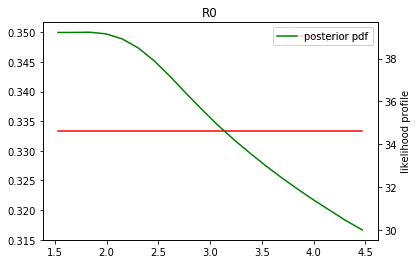

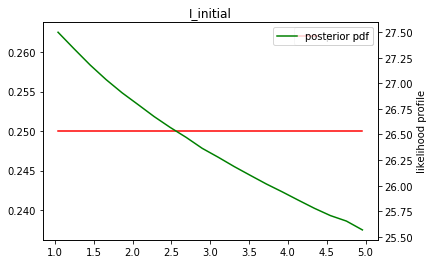

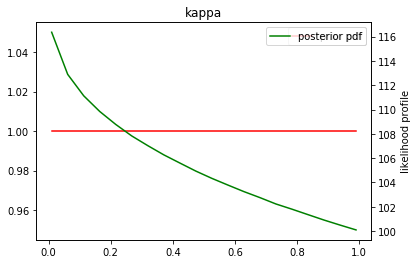

In [36]:
mf.plot_parameter_pdf()

In [31]:
mf.projection_end_time = 360
projection_stats = mf.run_projection()

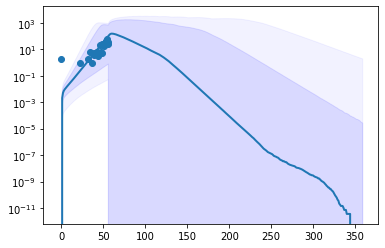

In [32]:
mf.plot_projection(projection_stats)

In [33]:
mf.projection_end_time = 360
projection_stats = mf.run_projection(error_augmentation=False)

Text(0.5, 1.0, 'No forecasting error adjustment')

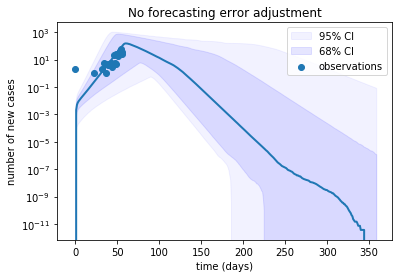

In [35]:
mf.plot_projection(projection_stats)
plt.ylabel('number of new cases')
plt.title('No forecasting error adjustment')